In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_observations(true_w, num, variance):
    d = len(true_w)
    X = np.random.multivariate_normal(np.zeros(d), variance * np.identity(d), size=num)
    z = np.exp(X @ true_w)
    probs = z / (1+z)
    y = np.random.rand(num) < probs
    return X, y.astype(int), true_w

In [22]:
d = 5
w = np.random.rand(d)
X, y, w = generate_observations(w, 10000, 1)

In [23]:
def log_liklihood(X, y, w):
    z = X@w
    return (y*z - np.log(1 + np.exp(z))).sum()

def grad_log_liklihood(X, y, w):
    z = np.exp(X@w)
    t = y - (z/(1+z))
    return (X*t[:,np.newaxis]).sum(axis=0)

In [24]:
log_liklihood(X, y, w)

-5283.985888161993

In [25]:
grad_log_liklihood(X, y, w)

array([ 50.72861702,  49.63127897, -57.16532498,   0.14593194,
        -3.19869549])

In [26]:
def do_gd(X, y, true_w, lr=0.001, max_iter=1000):
    vals = []
    grads = []
    mse = []
    w = np.ones(X.shape[1])
    grad = grad_log_liklihood(X, y, w)
    count = 0
    while np.linalg.norm(grad) > 1e-2 and count < max_iter:
        vals.append(log_liklihood(X, y, w))
        grads.append(np.linalg.norm(grad))
        mse.append(np.linalg.norm(w - true_w, ord=2))
        w += lr*grad
        grad = grad_log_liklihood(X, y, w)
        count += 1        
    return w, vals, grads, mse

0.6732 0.7063
0.9007 0.9350
0.8799 0.8531
0.3322 0.3352
0.0588 0.0578


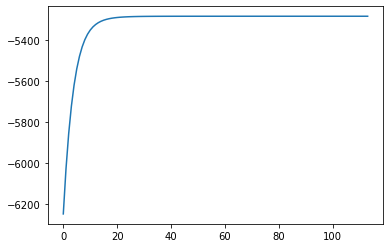

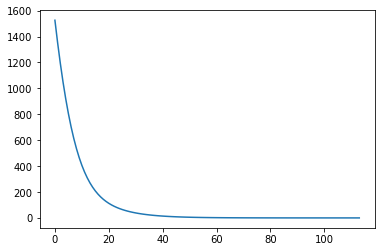

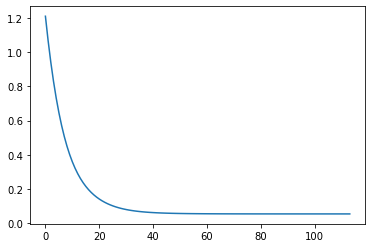

In [27]:
w_calc, vals, grads, mse = do_gd(X, y, w, lr=0.0001)

plt.plot(vals)

plt.figure()
plt.plot(grads)

plt.figure()
plt.plot(mse)

for i in range(len(w)):
    print("{:.4f} {:.4f}".format(w[i], w_calc[i]))